<a href="https://colab.research.google.com/github/emanuel379/Aprendizado-de-Maquina/blob/main/Atividade_1_Nivelamento_em_Minera%C3%A7%C3%A3o_de_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score

# Parte 1: observando e limpando a base de dados

obs: Student Performance Data é o resultado de uma pesquisa envolvendo alunos de matemática da escola secundária.

Queremos saber quais as principais características dos alunos aprovados no exame e se elas realmente são capazes de explicar o comportamento desses dados



In [ ]:
df = pd.read_csv("student_data.csv")
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


In [ ]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [ ]:
# Verificando a existência de componentes NaN
df.isna().sum()

,0
school,0
sex,0
age,0
address,0
famsize,0
Pstatus,0
Medu,0
Fedu,0
Mjob,0
Fjob,0


In [ ]:
# Observando a presença de duplicações
df.duplicated().sum()

0

In [ ]:
# Observando outra característica bastante utilizada quando não há dados
df.applymap(lambda x: x == '?').sum()

<ipython-input-6-abd9e385573b>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(lambda x: x == '?').sum()


,0
school,0
sex,0
age,0
address,0
famsize,0
Pstatus,0
Medu,0
Fedu,0
Mjob,0
Fjob,0


# Parte 2:  Pré-processamento

Aqui utilizaremos StandardScaler para padronizar as variáveis presentes no conjunto de dados e SelectKBest para selecionar as que possuem maior peso na capacidade de um aluno ser aprovado, ou não, no exame de matemática.



In [ ]:
# Padronizando as variáveis

df['sex'] = (df['sex'] == 'M').astype(int)
df['internet'] = (df['internet'] == 'yes').astype(int)
df['romantic'] = (df['romantic'] == 'yes').astype(int)
df['paid'] = (df['paid'] == 'yes').astype(int)
df['nursery'] = (df['nursery'] == 'yes').astype(int)
df['activities'] = (df['activities'] == 'yes').astype(int)

le = LabelEncoder()

df['famsize'] = le.fit_transform(df['famsize'])
df['school'] = le.fit_transform(df['school'])
df['Mjob'] = le.fit_transform(df['Mjob'])
df['Fjob'] = le.fit_transform(df['Fjob'])
df['reason'] = le.fit_transform(df['reason'])
df['guardian'] = le.fit_transform(df['guardian'])
df['address'] = le.fit_transform(df['address'])

scaler = StandardScaler()

features = ['school', 'sex', 'age', 'address', 'famsize', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'paid', 'activities', 'nursery',
       'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences']

X = df[features]

X_scaled = scaler.fit_transform(X)

X_scaled

array([[-0.3630498 , -0.94817639,  1.02304645, ..., -1.00378921,
        -0.39928949,  0.03642446],
       [-0.3630498 , -0.94817639,  0.23837976, ..., -1.00378921,
        -0.39928949, -0.21379577],
       [-0.3630498 , -0.94817639, -1.33095364, ...,  0.55109996,
        -0.39928949,  0.53686493],
       ...,
       [ 2.75444305,  1.05465609,  3.37704655, ...,  0.55109996,
        -0.39928949, -0.33890588],
       [ 2.75444305,  1.05465609,  1.02304645, ...,  1.32854454,
         1.04106985, -0.71423623],
       [ 2.75444305,  1.05465609,  1.80771315, ...,  0.55109996,
         1.04106985, -0.08868565]])

In [ ]:
# Definindo nossa variável target, queremos saber se o estudante foi aprovado ou não no teste de matemática

df['pass'] = df.apply(lambda row:1 if(row['G1']+row['G2']+row['G3'])>= 35 else 0,axis=1)
df = df.drop(['G1','G2','G3'],axis =1)

# Definindo a variável dependente que representa nossa target
y = df['pass']

# Utilizando SelectKBest para selecionar as 10 melhores features para o modelo
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_scaled, y)

# Obtendo os índices e nomes das features selecionadas
selected_indices = selector.get_support(indices=True)
selected_features = [features[i] for i in selected_indices]

print("Features selecionadas:", selected_features)

Features selecionadas: ['sex', 'age', 'Medu', 'Fedu', 'reason', 'traveltime', 'failures', 'goout', 'Dalc', 'Walc']


In [ ]:
X_selected

array([[-0.94817639,  1.02304645,  1.14385567, ...,  0.8014793 ,
        -0.54069866, -1.00378921],
       [-0.94817639,  0.23837976, -1.60000865, ..., -0.09790798,
        -0.54069866, -1.00378921],
       [-0.94817639, -1.33095364, -1.60000865, ..., -0.99729526,
         0.58338539,  0.55109996],
       ...,
       [ 1.05465609,  3.37704655, -1.60000865, ..., -0.09790798,
         1.70746944,  0.55109996],
       [ 1.05465609,  1.02304645,  0.22923423, ..., -1.89668255,
         1.70746944,  1.32854454],
       [ 1.05465609,  1.80771315, -1.60000865, ..., -0.09790798,
         1.70746944,  0.55109996]])

# Parte 3: Extração de Padrões e Pós-processamento

**Classificação**

Validação Cruzada


Folds: 10
Acurácias para cada fold: [0.525      0.675      0.65       0.6        0.575      0.53846154
 0.53846154 0.66666667 0.64102564 0.53846154]
Média das acurácias: 0.5948
Desvio padrão das acurácias: 0.0562

Folds: 15
Acurácias para cada fold: [0.55555556 0.62962963 0.55555556 0.74074074 0.62962963 0.57692308
 0.69230769 0.5        0.5        0.61538462 0.65384615 0.65384615
 0.57692308 0.65384615 0.46153846]
Média das acurácias: 0.5997
Desvio padrão das acurácias: 0.0745

Folds: 20
Acurácias para cada fold: [0.6        0.55       0.5        0.75       0.5        0.8
 0.7        0.6        0.75       0.5        0.55       0.6
 0.6        0.5        0.6        0.47368421 0.63157895 0.63157895
 0.52631579 0.68421053]
Média das acurácias: 0.6024
Desvio padrão das acurácias: 0.0923

Folds: 25
Acurácias para cada fold: [0.75       0.4375     0.6875     0.5625     0.6875     0.625
 0.75       0.625      0.75       0.625      0.75       0.5625
 0.625      0.5        0.5625     0.625   

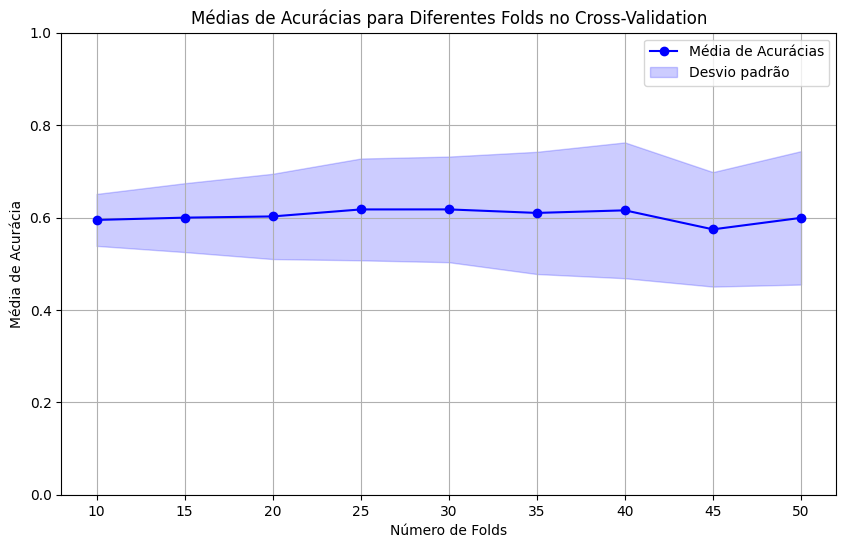

In [ ]:
# Definindo o classificador
clf = RandomForestClassifier(random_state=42)

# Listas para armazenar as médias de acurácias e desvios padrões para cada fold
mean_accuracies = []
std_accuracies = []
folds_range = range(10, 51, 5)  # Testando folds de 10 a 50, de 5 em 5

# Iterando sobre os diferentes números de folds
for folds in folds_range:
    scores = cross_val_score(clf, X_selected, y, cv=folds, scoring='accuracy')
    mean_accuracies.append(np.mean(scores))
    std_accuracies.append(np.std(scores))
    print(f"\nFolds: {folds}")
    print(f"Acurácias para cada fold: {scores}")
    print(f"Média das acurácias: {np.mean(scores):.4f}")
    print(f"Desvio padrão das acurácias: {np.std(scores):.4f}")

# Encontrando o melhor número de folds com base na média de acurácias
best_folds = folds_range[np.argmax(mean_accuracies)]
print(f"\nMelhor número de folds: {best_folds} com média de acurácia de {max(mean_accuracies):.4f}")

# Plotando as médias de acurácias
plt.figure(figsize=(10, 6))
plt.plot(folds_range, mean_accuracies, marker='o', linestyle='-', color='b', label='Média de Acurácias')
plt.fill_between(folds_range, np.array(mean_accuracies) - np.array(std_accuracies),
                 np.array(mean_accuracies) + np.array(std_accuracies), color='b', alpha=0.2, label='Desvio padrão')
plt.title('Médias de Acurácias para Diferentes Folds no Cross-Validation')
plt.xlabel('Número de Folds')
plt.ylabel('Média de Acurácia')
plt.ylim(0, 1)
plt.xticks(np.arange(10, 51, step=5))
plt.grid(True)
plt.legend()
plt.show()

É possível observar que para 30 folds obtivemos a maior acurácia média, em termos de maior acurácia, temos que com 35 folds foi possível obter um caso onde a acurácia foi de 0.91, porém possui maior desvio padrão e menor média que o de 30 folds

 Classificador KNN

Melhor valor de k: 4
Melhor métrica de distância: correlation
Melhor acurácia: 0.6424


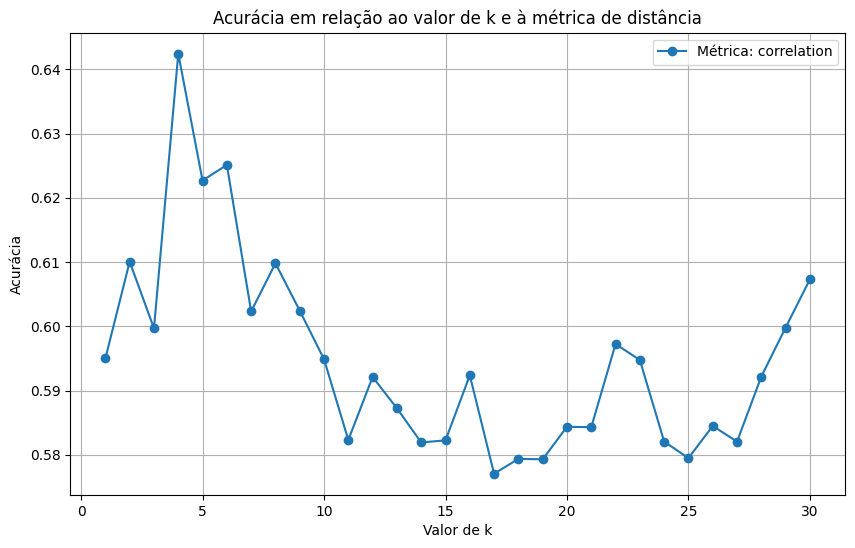

In [ ]:
# Configurando o classificador KNN
knn = KNeighborsClassifier()

# Definindo os parâmetros a serem testados no GridSearchCV
param_grid = {
    'n_neighbors': np.arange(1, 31),  # Testar valores de k de 1 a 30
    'metric': ['correlation']  # Medidas de similaridade
}

# Configurando o GridSearchCV
cv = StratifiedKFold(n_splits=10)
grid_search = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# Ajustando o modelo com GridSearchCV
grid_search.fit(X_selected, y)

# Exibindo os melhores parâmetros e a melhor acurácia
print(f"Melhor valor de k: {grid_search.best_params_['n_neighbors']}")
print(f"Melhor métrica de distância: {grid_search.best_params_['metric']}")
print(f"Melhor acurácia: {grid_search.best_score_:.4f}")

# Visualizando a acurácia em relação aos valores de k testados
results = grid_search.cv_results_

# Extraindo as acurácias para cada valor de k
mean_scores = np.array(results['mean_test_score']).reshape(len(param_grid['n_neighbors']), len(param_grid['metric']))

# Plotando as acurácias para cada métrica de distância
plt.figure(figsize=(10, 6))
for i, metric in enumerate(param_grid['metric']):
    plt.plot(param_grid['n_neighbors'], mean_scores[:, i], label=f'Métrica: {metric}', marker='o')

plt.title('Acurácia em relação ao valor de k e à métrica de distância')
plt.xlabel('Valor de k')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

Após testar várias distâncias(Mahalanobis, Minkowski, Euclideana, Manhattan, Chebschev e Correlação), obtivemos que a Correlação com 2 vizinhos foi a que maior acurácia obteve.

**Clustering**

K-means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para n_clusters = 2, o silhouette score é 0.1955
Para n_clusters = 3, o silhouette score é 0.1427
Para n_clusters = 4, o silhouette score é 0.1438
Para n_clusters = 5, o silhouette score é 0.1301


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Para n_clusters = 6, o silhouette score é 0.1224
Para n_clusters = 7, o silhouette score é 0.1212
Para n_clusters = 8, o silhouette score é 0.1197
Para n_clusters = 9, o silhouette score é 0.1169


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Para n_clusters = 10, o silhouette score é 0.1234

O melhor número de clusters é 2


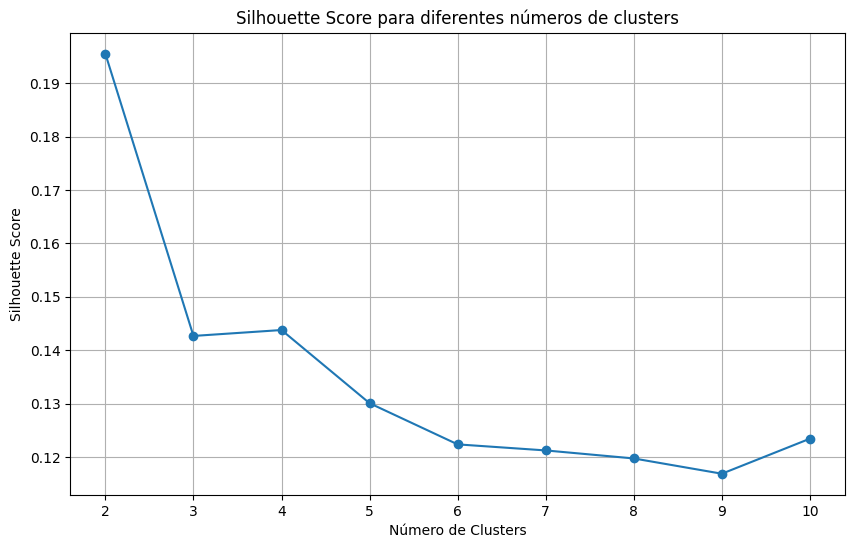

In [ ]:
# Definindo os dados a serem usados para o agrupamento
X_cluster = X_selected

# Lista para armazenar os silhouette scores
silhouette_scores = []

# Testar valores de k (número de clusters) de 2 a 10
range_n_clusters = range(2, 11)

for n_clusters in range_n_clusters:
    # Inicializando o modelo KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    # Ajustando o modelo aos dados
    cluster_labels = kmeans.fit_predict(X_cluster)

    # Calculando o silhouette score para o número de clusters atual
    silhouette_avg = silhouette_score(X_cluster, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    print(f"Para n_clusters = {n_clusters}, o silhouette score é {silhouette_avg:.4f}")

# Determinando o melhor número de clusters (com o maior silhouette score)
best_n_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"\nO melhor número de clusters é {best_n_clusters}")

# Plotando o silhouette score para cada número de clusters
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score para diferentes números de clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

Avaliação de Qualidade

In [ ]:
# Definindo o melhor número de clusters obtidos com a análise anterior
best_n_clusters = 2

# Executando o K-Means para esse número
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Calculando o Rand Index ajustado
ari_score = adjusted_rand_score(y, cluster_labels)

# Exibe o resultado
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

Adjusted Rand Index (ARI): 0.0107


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Sendo o Adjusted Rand Index (ARI) uma métrica entre -1 e 1, tal que:

1: indica elevada qualidade do modelo no ajuste dos dados.

0: indica baixa qualidade e, logo, um ajuste ruim.

-1: indica péssima qualida, indicando que o modelo não conseguiu captar o comportamento dos dados.

Temos que o valor obtido de 0.0107 implica em um ajuste ruim, semelhante a um processo de seleção aleatório.

# Resultado final:

Tanto na classificação quanto na clusterização, não obtivemos resultados satisfatórios, entretanto, enquanto na clusterização o método K-Means nos trouxe um resultado ineficiente, para a classificação a Validação Cruzada e o KNN nos retornaram acurácias em torno de 0.6, um resultado não tão bom, porém utilizável e que poderia ser otimizado futuramente.